In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib
# matplotlib.use('agg')
# matplotlib.use('TkAgg')
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [2]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm  

# Global Setting

## Galaxy information

In [3]:
c = 299792.458  # spped of light [km/s]

galaxy_name = 'VCC_1588'
spectrum_filename = 'VCC1588_stack.fits'
spectrum_z = 0.0042

## basic fitting parameters

In [4]:
lam_range_temp = [4820, 5220]
redshift = spectrum_z           # redshift from
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [5]:
# templates

sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [6]:
# vel_s = c * spectrum_z
vel_s = 0
vel_dis_s = 40 # Set the dis v = 40 km/s

# Data Input

In [7]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)

        self.velfield = np.ndarray(shape=self.cube.shape[1:3])
        self.sigfield = np.ndarray(shape=self.cube.shape[1:3])

        # self.CD1_1 = self.CD1_1
        # self.CD1_2 = self.CD1_2
        # self.CD2_1 = self.CD2_1
        # self.CD2_2 = self.CD2_2
        # self.CRVAL1 = self.CRVAL1
        # self.CRVAL2 = self.CRVAL2

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """

        Cut_LHS = 150
        Cut_RHS = 150

        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:] * (10 ** 18)
        # cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:]
        # cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0]) + head['CD3_3']*Cut_LHS

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600

        self.CD1_1 = head['CD1_1']
        self.CD1_2 = head['CD1_2']
        self.CD2_1 = head['CD2_1']
        self.CD2_2 = head['CD2_2']
        self.CRVAL1 = head['CRVAL1']
        self.CRVAL2 = head['CRVAL2']

In [8]:
Galaxy_info = read_data_cube(objfile, lam_range_temp, redshift)

# Fitting

## Parameters pre-set

In [9]:
FWHM_gal = None   # set this to None to skip templates broadening
sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal, norm_range=[4827.875, 5206.375])
# sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal)

In [10]:
npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0 = util.determine_mask(Galaxy_info.ln_lam_gal, lam_range_temp, width=1000)
# nbins = np.unique(bin_num).size
# velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
# optimal_templates = np.empty((npix, nbins))
lam_gal = np.exp(Galaxy_info.ln_lam_gal)

## FTF (First time fitting)

In [11]:
def Cube_sol(Galaxy_cube, redshift):
    
    plt.figure(figsize=(16, 3))
    ##-----------------------------------------------
    galaxies = np.ndarray(shape= (Galaxy_cube.spectra[:,0].shape[0],Galaxy_cube.cube.shape[1],Galaxy_cube.cube.shape[2]))
    # print(Galaxy_cube.cube.shape)
    for i in range(Galaxy_cube.cube.shape[1]):
        for j in range(Galaxy_cube.cube.shape[2]):
            # galaxy,logLam1,velscale = util.log_rebin(np.array([np.min(Galaxy_cube.wave), np.max(Galaxy_cube.wave)]),Galaxy_cube.cube[:,i,j])
            # galaxy = galaxy/np.median(galaxy)

            galaxies[:,i,j] = Galaxy_cube.spectra[:,i*max(Galaxy_cube.col)+j]
    # plt.plot(galaxies[:,10,20])

    # logLam10 = logLam1[:]
    # logLam1 = logLam10[200:-200]

    velscale_ratio = 2
    velscale = Galaxy_cube.velscale

    velfield = np.ndarray(shape=galaxies.shape[1:3])+np.nan
    sigfield = np.ndarray(shape=galaxies.shape[1:3])+np.nan
    tempnum = np.ndarray(shape=galaxies.shape[1:3])
    Bestfitfield = np.ndarray(shape=galaxies.shape)

    optimal_templates = np.ndarray(shape=(npix,galaxies.shape[1],galaxies.shape[2]))
    # pp_field = [[None]*Galaxy_cube.cube.shape[2]]*Galaxy_cube.cube.shape[1]
    # print(pp_field[0][1])

    for i in tqdm(range(galaxies.shape[1])):
        for j in range(galaxies.shape[2]):
            # if(i == 11 and j == 43):                 # -------------------------- Here is the test sentence -------------------------- Here is the test sentence
                plot_TF = True if (i == 11 and j == 43) else False
                tmpgalaxy = galaxies[:,i,j]
                noise = np.full_like(tmpgalaxy,0.1)
                noise = np.ones_like(tmpgalaxy)
                if np.count_nonzero(tmpgalaxy) > 50:
                    pp = ppxf(sps.templates, tmpgalaxy, noise, velscale, [vel_s, vel_dis_s],
                            plot=plot_TF, mask=mask0, lam=lam_gal, lam_temp=sps.lam_temp, quiet=not plot_TF)
                    # pp_field[i][j]=pp
                    Bestfitfield[:,i,j]=pp.bestfit

                    pp.optimal_template = sps.templates.reshape(sps.templates.shape[0], -1) @ pp.weights
                    optimal_templates[:,i,j] = pp.optimal_template
                    velfield[i,j] = pp.sol[0]
                    sigfield[i,j] = pp.sol[1]
                    weights = pp.weights
                    indwt = np.where(weights == np.max(weights))[0]
                    tempnum[i,j] = indwt[0]

    # return velfield, sigfield, pp_field
    return velfield, sigfield, Bestfitfield, optimal_templates

  0%|          | 0/23 [00:00<?, ?it/s]c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\capfit\capfit.py:811: RuntimeWarning: invalid value encountered in scalar divide
  ratio = actred/prered
 48%|████▊     | 11/23 [03:48<04:25, 22.13s/it]

 Best Fit:       Vel     sigma
 comp.  0:        34        12
chi2/DOF: 36.71; DOF: 1555; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 21; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 7/150


100%|██████████| 23/23 [09:23<00:00, 24.52s/it]


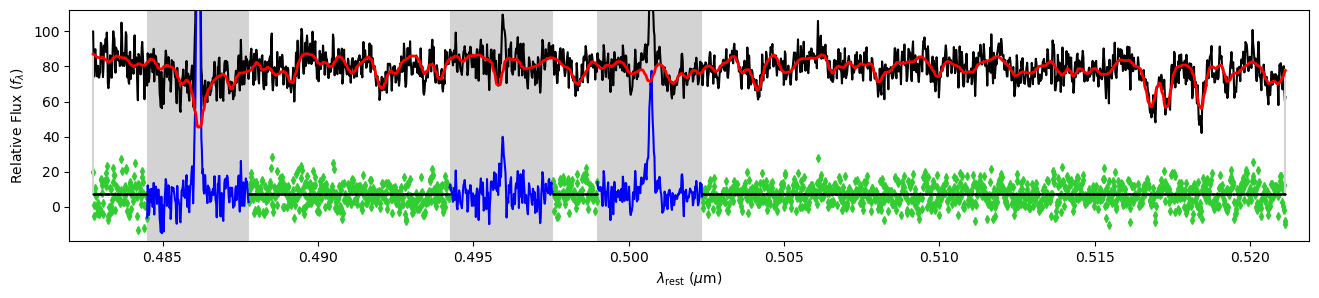

In [12]:
velfield, sigfield, Bestfitfield, optimal_templates = Cube_sol(Galaxy_info, redshift)

In [13]:
Index_Wave = pd.DataFrame({
        'Index':['H_beta','Fe_5015','Mg_b','Fe_5270','Fe_5270_s'],
        'BPC_range':[[4827.875,4847.875],[4946.500,4977.750],[5142.625,5161.375],[5233.150,5248.150],[5233.000,5250.000]],
        'CBP_range':[[4847.875,4876.625],[4977.750,5054.000],[5160.125,5192.625],[5245.650,5285.650],[5256.500,5278.500]],
        'RPC_range':[[4876.625,4891.625],[5054.000,5065.250],[5191.375,5206.375],[5285.650,5318.150],[5285.500,5308.000]]
})

In [14]:
Index_use = [0,1,2]

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_24176\2263627391.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


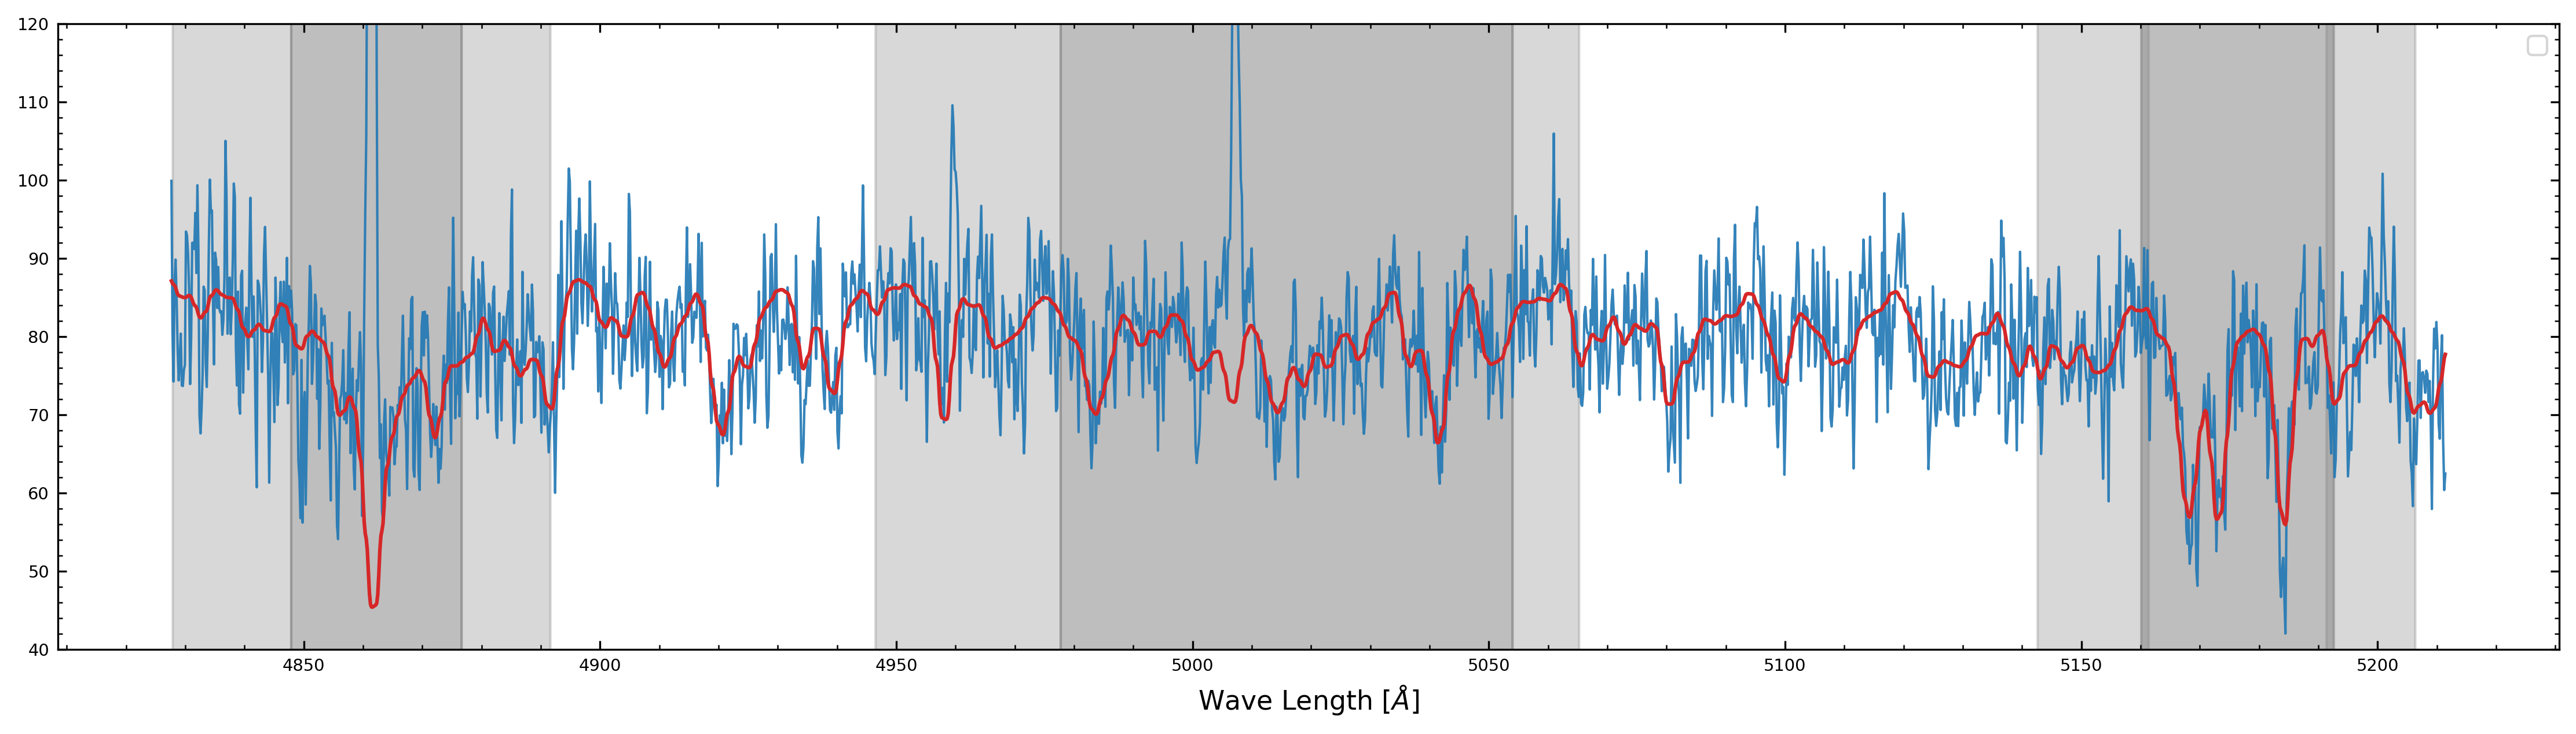

In [15]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,1000], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,43], c='tab:red')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(40,120)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

## STF (second time fitting)

### STF parameters setting

In [16]:
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, Galaxy_info.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' '[OIII]5007_d']


In [17]:
ngas_comp = 1   # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

In [18]:
galaxies = np.ndarray(shape= (Galaxy_info.spectra[:,0].shape[0],Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))

### Fitting

In [19]:
Galaxy_info

  0%|          | 0/23 [00:00<?, ?it/s]

differential_evolution step 1: f(x)= 252199
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:        24        22
chi2/DOF: 119.7; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0      52.9         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      52.85       3.3      24    22
Comp:  1      [OIII]5007_d_(1)      0.000       4.2      24    22
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 321890
 Best Fit:       Vel     sigma
 comp.  0:       132        20
 comp.  1:       300        20
chi2/DOF: 152.8; DOF: 2106; degree = 8; mdegree = 0
Global search - 

  4%|▍         | 1/23 [00:24<08:52, 24.20s/it]

differential_evolution step 1: f(x)= 305543
 Best Fit:       Vel     sigma
 comp.  0:     -1026       300
 comp.  1:      -830        20
chi2/DOF: 144.9; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
    0.0484       150         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      149.7       3.3    -830    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1    -830    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 341931
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:      -189        34
chi2/DOF: 162.4; DOF: 2106; degree = 8; mdegree = 0
Global search -

  9%|▊         | 2/23 [00:49<08:39, 24.72s/it]

differential_evolution step 1: f(x)= 189524
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:      -200        36
chi2/DOF: 89.98; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 4; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0      53.1         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      53.07       3.8    -200    36
Comp:  1      [OIII]5007_d_(1)      0.000       4.8    -200    36
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 132401
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       200        97
chi2/DOF: 62.87; DOF: 2106; degree = 8; mdegree = 0
Global search -

 13%|█▎        | 3/23 [01:12<07:56, 23.80s/it]

 Best Fit:       Vel     sigma
 comp.  0:       -79       300
 comp.  1:       104        32
chi2/DOF: 55.43; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0         0      52.6
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      0.000       3.7     104    32
Comp:  1      [OIII]5007_d_(1)      69.95       4.6     104    32
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 126190
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       200        78
chi2/DOF: 59.91; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2

 17%|█▋        | 4/23 [01:32<07:03, 22.31s/it]

differential_evolution step 1: f(x)= 144036
 Best Fit:       Vel     sigma
 comp.  0:     -1255        20
 comp.  1:     -1076        20
chi2/DOF: 68.38; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.247      22.4      51.1
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      22.39       3.3   -1076    20
Comp:  1      [OIII]5007_d_(1)      67.95       4.1   -1076    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 106672
 Best Fit:       Vel     sigma
 comp.  0:       -84        20
 comp.  1:       -34        20
chi2/DOF: 50.64; DOF: 2106; degree = 8; mdegree = 0
Global search - 

 22%|██▏       | 5/23 [01:56<06:54, 23.05s/it]

differential_evolution step 1: f(x)= 81748.1
 Best Fit:       Vel     sigma
 comp.  0:       -48        20
 comp.  1:       118       100
chi2/DOF: 38.81; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
      2.33       219         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      218.9       5.8     118   100
Comp:  1      [OIII]5007_d_(1)      0.000       7.3     118   100
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 174631
 Best Fit:       Vel     sigma
 comp.  0:       213        20
 comp.  1:       273        20
chi2/DOF: 82.91; DOF: 2106; degree = 8; mdegree = 0
Global search -

 26%|██▌       | 6/23 [02:22<06:51, 24.18s/it]

differential_evolution step 1: f(x)= 85372.5
 Best Fit:       Vel     sigma
 comp.  0:       221        78
 comp.  1:       410        39
chi2/DOF: 40.54; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.309      45.5      31.3
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      45.45       3.9     410    39
Comp:  1      [OIII]5007_d_(1)      41.65       4.9     410    39
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 194682
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       200       100
chi2/DOF: 92.36; DOF: 2106; degree = 8; mdegree = 0
Global search -

 30%|███       | 7/23 [02:49<06:37, 24.86s/it]

differential_evolution step 1: f(x)= 66457.3
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       -95        20
chi2/DOF: 31.55; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0      70.2      26.1
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      70.22       3.3     -95    20
Comp:  1      [OIII]5007_d_(1)      34.71       4.1     -95    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 112875
 Best Fit:       Vel     sigma
 comp.  0:      -122        20
 comp.  1:      -185        73
chi2/DOF: 53.60; DOF: 2106; degree = 8; mdegree = 0
Global search -

 35%|███▍      | 8/23 [03:12<06:04, 24.30s/it]

differential_evolution step 1: f(x)= 73645.6
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       157        31
chi2/DOF: 34.97; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 12; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0      39.1      4.68
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      39.09       3.7     157    31
Comp:  1      [OIII]5007_d_(1)      6.228       4.6     157    31
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 182693
 Best Fit:       Vel     sigma
 comp.  0:      -190        20
 comp.  1:       -92        20
chi2/DOF: 86.74; DOF: 2106; degree = 8; mdegree = 0
Global search 

 39%|███▉      | 9/23 [03:39<05:55, 25.41s/it]

differential_evolution step 1: f(x)= 64160.8
 Best Fit:       Vel     sigma
 comp.  0:      -203       100
 comp.  1:      -274        20
chi2/DOF: 30.46; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.74      57.1      30.4
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      57.15       3.3    -274    20
Comp:  1      [OIII]5007_d_(1)      40.44       4.1    -274    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 133812
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       -36        20
chi2/DOF: 63.44; DOF: 2106; degree = 8; mdegree = 0
Global search 

 43%|████▎     | 10/23 [04:21<06:35, 30.42s/it]

differential_evolution step 1: f(x)= 65555.7
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:      -141        20
chi2/DOF: 31.12; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0         0        19
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      0.000       3.3    -141    20
Comp:  1      [OIII]5007_d_(1)      25.25       4.1    -141    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 150173
 Best Fit:       Vel     sigma
 comp.  0:         9        86
 comp.  1:        50        20
chi2/DOF: 71.30; DOF: 2106; degree = 8; mdegree = 0
Global search -

 48%|████▊     | 11/23 [05:06<06:58, 34.87s/it]

differential_evolution step 1: f(x)= 79738.5
 Best Fit:       Vel     sigma
 comp.  0:        26        20
 comp.  1:      -174        20
chi2/DOF: 37.84; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
      1.64        32         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      31.99       3.3    -174    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1    -174    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 146940
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:      -103        20
chi2/DOF: 69.76; DOF: 2106; degree = 8; mdegree = 0
Global search -

 52%|█████▏    | 12/23 [05:57<07:16, 39.68s/it]

differential_evolution step 1: f(x)= 172469
 Best Fit:       Vel     sigma
 comp.  0:         1        20
 comp.  1:       107        52
chi2/DOF: 81.89; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0      51.8      65.8
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      51.80       4.4     107    52
Comp:  1      [OIII]5007_d_(1)      87.48       5.5     107    52
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 109824
 Best Fit:       Vel     sigma
 comp.  0:       -98        20
 comp.  1:      -140        38
chi2/DOF: 52.14; DOF: 2106; degree = 8; mdegree = 0
Global search - 

 57%|█████▋    | 13/23 [06:42<06:55, 41.51s/it]

differential_evolution step 1: f(x)= 78764
 Best Fit:       Vel     sigma
 comp.  0:       -30        20
 comp.  1:       -51        40
chi2/DOF: 37.40; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.538      91.6         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      91.57       3.9     -51    40
Comp:  1      [OIII]5007_d_(1)      0.000       4.9     -51    40
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 711823
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       -56        71
chi2/DOF: 337.2; DOF: 2106; degree = 8; mdegree = 0
Global search - 

 61%|██████    | 14/23 [07:22<06:09, 41.04s/it]

differential_evolution step 1: f(x)= 96921.7
 Best Fit:       Vel     sigma
 comp.  0:       -85        20
 comp.  1:       -57        20
chi2/DOF: 46.01; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
      1.86      78.8         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      78.84       3.3     -57    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1     -57    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.68357e+07
 Best Fit:       Vel     sigma
 comp.  0:       -97        20
 comp.  1:      -155        48
chi2/DOF: 7986.; DOF: 2106; degree = 8; mdegree = 0
Global sea

 65%|██████▌   | 15/23 [08:03<05:27, 40.92s/it]

differential_evolution step 1: f(x)= 105768
 Best Fit:       Vel     sigma
 comp.  0:       328        52
 comp.  1:       399        20
chi2/DOF: 50.20; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.04        45      9.65
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      45.05       3.3     399    20
Comp:  1      [OIII]5007_d_(1)      12.83       4.1     399    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.59725e+06
 Best Fit:       Vel     sigma
 comp.  0:       -97        20
 comp.  1:      -156        49
chi2/DOF: 757.9; DOF: 2106; degree = 8; mdegree = 0
Global sea

 70%|██████▉   | 16/23 [08:36<04:30, 38.64s/it]

differential_evolution step 1: f(x)= 105253
 Best Fit:       Vel     sigma
 comp.  0:        30        20
 comp.  1:      -154        53
chi2/DOF: 49.98; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.727         0        48
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      0.000       4.4    -154    53
Comp:  1      [OIII]5007_d_(1)      63.88       5.5    -154    53
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 301139
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       -32       100
chi2/DOF: 142.9; DOF: 2106; degree = 8; mdegree = 0
Global search - 

 74%|███████▍  | 17/23 [09:13<03:48, 38.10s/it]

differential_evolution step 1: f(x)= 100929
 Best Fit:       Vel     sigma
 comp.  0:       375       279
 comp.  1:       575       100
chi2/DOF: 47.92; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.119       117      3.04
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      117.5       5.8     575   100
Comp:  1      [OIII]5007_d_(1)      4.046       7.3     575   100
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 113188
 Best Fit:       Vel     sigma
 comp.  0:      -109        20
 comp.  1:        91       100
chi2/DOF: 53.74; DOF: 2106; degree = 8; mdegree = 0
Global search - 

 78%|███████▊  | 18/23 [09:47<03:04, 36.90s/it]

differential_evolution step 1: f(x)= 116242
 Best Fit:       Vel     sigma
 comp.  0:       196        40
 comp.  1:       176        20
chi2/DOF: 55.15; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.525       102         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      102.3       3.3     176    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1     176    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 140941
 Best Fit:       Vel     sigma
 comp.  0:       263       100
 comp.  1:       140        20
chi2/DOF: 66.91; DOF: 2106; degree = 8; mdegree = 0
Global search -

 83%|████████▎ | 19/23 [10:33<02:37, 39.45s/it]

differential_evolution step 1: f(x)= 102827
 Best Fit:       Vel     sigma
 comp.  0:      -102       300
 comp.  1:       -18        20
chi2/DOF: 48.81; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0      46.5      36.3
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      46.48       3.3     -18    20
Comp:  1      [OIII]5007_d_(1)      48.31       4.1     -18    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 262779
 Best Fit:       Vel     sigma
 comp.  0:       -98        27
 comp.  1:        13       100
chi2/DOF: 124.8; DOF: 2106; degree = 8; mdegree = 0
Global search -

 87%|████████▋ | 20/23 [11:15<02:00, 40.26s/it]

differential_evolution step 1: f(x)= 129541
 Best Fit:       Vel     sigma
 comp.  0:       171        20
 comp.  1:       132        29
chi2/DOF: 61.50; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.256       125      7.22
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      124.9       3.6     132    29
Comp:  1      [OIII]5007_d_(1)      9.599       4.5     132    29
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 284553
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       112        20
chi2/DOF: 135.1; DOF: 2106; degree = 8; mdegree = 0
Global search - 

 91%|█████████▏| 21/23 [11:56<01:21, 40.65s/it]

differential_evolution step 1: f(x)= 142225
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:        97        20
chi2/DOF: 67.48; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0       144      2.52
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      143.9       3.3      97    20
Comp:  1      [OIII]5007_d_(1)      3.357       4.1      97    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 308949
 Best Fit:       Vel     sigma
 comp.  0:        81        20
 comp.  1:       241       100
chi2/DOF: 146.7; DOF: 2106; degree = 8; mdegree = 0
Global search - 

 96%|█████████▌| 22/23 [12:40<00:41, 41.49s/it]

differential_evolution step 1: f(x)= 167077
 Best Fit:       Vel     sigma
 comp.  0:       232        20
 comp.  1:        92        20
chi2/DOF: 79.24; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
    0.0885       137         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      137.4       3.3      92    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1      92    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 379688
 Best Fit:       Vel     sigma
 comp.  0:      -946       300
 comp.  1:      -840        20
chi2/DOF: 180.2; DOF: 2106; degree = 8; mdegree = 0
Global search - 

100%|██████████| 23/23 [13:26<00:00, 35.06s/it]

differential_evolution step 1: f(x)= 201053
 Best Fit:       Vel     sigma
 comp.  0:       288        92
 comp.  1:       276       100
chi2/DOF: 95.45; DOF: 2106; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
     0.326       355         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      354.5       5.8     276   100
Comp:  1      [OIII]5007_d_(1)      0.000       7.3     276   100
-----------------------------------------------------------------


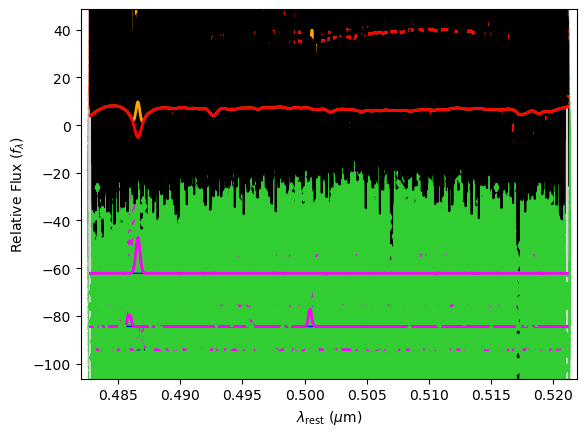

In [20]:
PP_box = []
for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        galaxy = Galaxy_info.spectra[:,i*max(Galaxy_info.col)+j]
        noise = np.ones_like(galaxy)

        template = optimal_templates[:,i,j]
        stars_gas_templates = np.column_stack([template, gas_templates])

        component = [0] + [1]*2
        gas_component=np.array(component) > 0
        moments = [-2, 2]
        ncomp = len(moments)
        tied = [['', ''] for _ in range(ncomp)]

        start = [[velfield[i,j], sigfield[i,j]],
        [velfield[i,j], 50]]

        vlim = lambda x: velfield[i,j] + x*np.array([-100, 100])
        bounds = [[vlim(2), [20, 300]],
                  [vlim(2), [20, 100]]]

        pp = ppxf(stars_gas_templates, galaxy, noise, Galaxy_info.velscale, start,
            plot=1, moments=moments, degree=8, mdegree=-1, component=component, 
            gas_component=gas_component, gas_names=gas_names,
            lam=lam_gal, lam_temp=sps.lam_temp, tied=tied,
            bounds=bounds,
            global_search=True)
        
        PP_box += [pp]

In [21]:
# def CK_SpFT(I_index, J_index):
#     K_index = I_index*max(Galaxy_info.col)+J_index

#     fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,12), dpi=300, tight_layout=True)
#     gs1 = gridspec.GridSpec(1, 1)
#     gs1.update(left=0.05, right=.95, bottom=0.65, top=0.95, hspace=0.0)
#     ax1 = plt.subplot(gs1[0])

#     gs2 = gridspec.GridSpec(1, 1)
#     gs2.update(left=0.05, right=.95, bottom=0.35, top=0.65, hspace=0.0)
#     ax2 = plt.subplot(gs2[0])

#     gs3 = gridspec.GridSpec(1, 1)
#     gs3.update(left=0.05, right=.95, bottom=0.05, top=0.35, hspace=0.0)
#     ax3 = plt.subplot(gs3[0])


# # -------------------------------------------------------------------------------------------------------------------------------------

#     ax1.plot(lam_gal,Galaxy_info.spectra[:,K_index], c='tab:blue', lw=1, alpha=.9, label=galaxy_name+'\npixel:[{:},{:}]'.format(I_index, J_index))
#     ax1.plot(lam_gal,Bestfitfield[:,I_index,J_index], '--', c='tab:red', alpha=.9)

#     for i in Index_use:
#         LHS = Index_Wave.loc[i,'CBP_range'][0]
#         RHS = Index_Wave.loc[i,'CBP_range'][1]
#         ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
#         ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
#         ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)

#     for i in Index_use:
#         LHS = Index_Wave.loc[i,'BPC_range'][0]
#         RHS = Index_Wave.loc[i,'BPC_range'][1]
#         ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
#         ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
#         ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
#     for i in Index_use:
#         LHS = Index_Wave.loc[i,'RPC_range'][0]
#         RHS = Index_Wave.loc[i,'RPC_range'][1]
#         ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
#         ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
#         ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)

#     for i in [0]:
#         ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 1, alpha=.9)

#     for i in [1]:
#         ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 1, alpha=.9)

#     ax1.plot(lam_gal,PP_box[K_index].bestfit, '-', lw=.7, c='tab:red')


# # -------------------------------------------------------------------------------------------------------------------------------------

#     ax2.plot(lam_gal, np.zeros(lam_gal.shape), '-', color='k', lw=.7, alpha=.9, zorder = 0)
#     ax2.plot(lam_gal, [np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)]*lam_gal.shape[0], '--', color='tab:blue', lw=1, alpha=.9, zorder = 1)
#     MPSig = np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit) + np.std(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)
#     MMSig = np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit) - np.std(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)
#     ax2.fill([min(lam_gal), max(lam_gal), max(lam_gal), min(lam_gal)], [MPSig, MPSig, MMSig, MMSig], color='tab:gray', alpha=.2,
#              label=r'Raange:{:1.3f}$\pm${:1.3f}'.format(np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit), np.std(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)), zorder=1)
#     ax2.plot(lam_gal, Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit, '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)

# # -------------------------------------------------------------------------------------------------------------------------------------

#     ax3.plot(lam_gal, Galaxy_info.spectra[:,K_index]-Bestfitfield[:,I_index,J_index], '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)
#     for i in [0]:
#         ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 2, alpha=.9)
#     for i in [1]:
#         ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 2, alpha=.9)
    
#     ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,0]+PP_box[K_index].gas_bestfit_templates[:,1, ], lw=.7, color='tab:red', zorder = 2, alpha=.9)


# # -------------------------------------------------------------------------------------------------------------------------------------


#     ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
#     ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
#     ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
#     ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
#     ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
#     ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
#     ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
#     ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
#     ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    

#     ax1.set_xlim(min(lam_gal), max(lam_gal))
#     ax2.set_xlim(min(lam_gal), max(lam_gal))
#     ax3.set_xlim(min(lam_gal), max(lam_gal))
#     ax1.set_ylim(0,max(Galaxy_info.spectra[:,K_index])*1.1)
#     ax2.set_ylim(min(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)*1.2, max(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)*1.2)
#     ax3.set_ylim(min(Galaxy_info.spectra[:,K_index]-Bestfitfield[:,I_index,J_index])*1.2, max(Galaxy_info.spectra[:,K_index]-Bestfitfield[:,I_index,J_index])*1.2)

#     ax3.set_xlabel(r'Wave Length $[\AA]$', size=11)
    
#     ax1.legend()
#     ax2.legend()
#     # ax3.legend()

#     plt.savefig('./../FitPlot/Fit_02[24Oct22][VCC1588FullFit]/'+galaxy_name+'Fig[{:}]{:}-{:}.pdf'.format(K_index,I_index,J_index), format='pdf', bbox_inches='tight')
#     plt.clf()
#     plt.close()

#     PP_box[K_index] = []

## Fit spectrum plot

In [22]:
def CK_SpFT(I_index, J_index):
    K_index = I_index*max(Galaxy_info.col)+J_index

    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,12), dpi=300, tight_layout=True)
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=.95, bottom=0.65, top=0.95, hspace=0.0)
    ax1 = plt.subplot(gs1[0])

    gs2 = gridspec.GridSpec(1, 1)
    gs2.update(left=0.05, right=.95, bottom=0.35, top=0.65, hspace=0.0)
    ax2 = plt.subplot(gs2[0])

    gs3 = gridspec.GridSpec(1, 1)
    gs3.update(left=0.05, right=.95, bottom=0.05, top=0.35, hspace=0.0)
    ax3 = plt.subplot(gs3[0])


# -------------------------------------------------------------------------------------------------------------------------------------

    ax1.plot(lam_gal,Galaxy_info.spectra[:,K_index], c='tab:blue', lw=1, alpha=.9, label=galaxy_name+'\npixel:[{:},{:}]'.format(I_index, J_index))
    ax1.plot(lam_gal,Bestfitfield[:,I_index,J_index], '--', c='tab:red', alpha=.9)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'CBP_range'][0]
        RHS = Index_Wave.loc[i,'CBP_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'BPC_range'][0]
        RHS = Index_Wave.loc[i,'BPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
    for i in Index_use:
        LHS = Index_Wave.loc[i,'RPC_range'][0]
        RHS = Index_Wave.loc[i,'RPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)

    for i in [0]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 1, alpha=.9)

    for i in [1]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 1, alpha=.9)

    ax1.plot(lam_gal,PP_box[K_index].bestfit, '-', lw=.7, c='tab:red')


# -------------------------------------------------------------------------------------------------------------------------------------

    ax2.plot(lam_gal, np.zeros(lam_gal.shape), '-', color='k', lw=.7, alpha=.9, zorder = 0)
    ax2.plot(lam_gal, [np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)]*lam_gal.shape[0], '--', color='tab:blue', lw=1, alpha=.9, zorder = 1)
    MPSig = np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit) + np.std(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)
    MMSig = np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit) - np.std(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)
    ax2.fill([min(lam_gal), max(lam_gal), max(lam_gal), min(lam_gal)], [MPSig, MPSig, MMSig, MMSig], color='tab:gray', alpha=.2,
             label=r'Raange:{:1.3f}$\pm${:1.3f}'.format(np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit), np.std(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)), zorder=1)
    ax2.plot(lam_gal, Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit, '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)

# -------------------------------------------------------------------------------------------------------------------------------------

    ax3.plot(lam_gal, Galaxy_info.spectra[:,K_index]-Bestfitfield[:,I_index,J_index], '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)
    for i in [0]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 2, alpha=.9)
    for i in [1]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 2, alpha=.9)
    
    ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,0]+PP_box[K_index].gas_bestfit_templates[:,1, ], lw=.7, color='tab:red', zorder = 2, alpha=.9)


# -------------------------------------------------------------------------------------------------------------------------------------


    ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    

    ax1.set_xlim(min(lam_gal), max(lam_gal))
    ax2.set_xlim(min(lam_gal), max(lam_gal))
    ax3.set_xlim(min(lam_gal), max(lam_gal))
    ax1.set_ylim(0,max(Galaxy_info.spectra[:,K_index])*1.1)
    ax2.set_ylim(min(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)*1.2, max(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)*1.2)
    ax3.set_ylim(min(Galaxy_info.spectra[:,K_index]-Bestfitfield[:,I_index,J_index])*1.2, max(Galaxy_info.spectra[:,K_index]-Bestfitfield[:,I_index,J_index])*1.2)

    ax3.set_xlabel(r'Wave Length $[\AA]$', size=11)
    
    ax1.legend()
    ax2.legend()
    # ax3.legend()

    plt.savefig('./../../FitPlot/Fit_08[24Dec17][VCC1588RDBFit]/P2P_res/'+galaxy_name+'Fig[{:}]{:}-{:}_SPTest.pdf'.format(K_index,I_index,J_index), format='pdf', bbox_inches='tight')
    plt.clf()
    plt.close()

    PP_box[K_index] = []

In [23]:
# for i in tqdm(range(galaxies.shape[1])):
#     for j in range(galaxies.shape[2]):
#         # CK_SpFT(i,j)

# # CK_SpFT(10,51)

# Spectrum Index

In [24]:
H_Beta_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])
Fe_5015_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])
Mg_b_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])

In [25]:
LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])

In [26]:
x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))

In [27]:
for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        
        K_index = i*max(Galaxy_info.col)+j
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]


        LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])
        LCB = Index_Wave.loc[0,'CBP_range'][0]
        RCB = Index_Wave.loc[0,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i,j] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i,j] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i,j] = x_wave[:,i,j] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i,j] - y_spectrum[:,i,j]
        for k in range(len(y_SL[:,i,j])):
            NS[k] = (NS[k]/y_SL[k,i,j])

        H_Beta_map[i,j] = np.trapz(NS, x_wave[:,i,j])

100%|██████████| 23/23 [00:00<00:00, 25.04it/s]


In [28]:
#Fe 5015

LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])

In [29]:
#Fe 5015

x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))

In [30]:
#Fe 5015

for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        
        K_index = i*max(Galaxy_info.col)+j
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]

        LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])
        LCB = Index_Wave.loc[1,'CBP_range'][0]
        RCB = Index_Wave.loc[1,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i,j] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i,j] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i,j] = x_wave[:,i,j] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i,j] - y_spectrum[:,i,j]
        for k in range(len(y_SL[:,i,j])):
            NS[k] = NS[k]/y_SL[k,i,j]

        Fe_5015_map[i,j] = np.trapz(NS, x_wave[:,i,j])

100%|██████████| 23/23 [00:01<00:00, 18.83it/s]


In [31]:
#Mg b

LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])

In [32]:
#Mg b

x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))

In [33]:
#Mg b

for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        
        K_index = i*max(Galaxy_info.col)+j
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]


        LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])
        LCB = Index_Wave.loc[2,'CBP_range'][0]
        RCB = Index_Wave.loc[2,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i,j] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i,j] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i,j] = x_wave[:,i,j] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i,j] - y_spectrum[:,i,j]
        for k in range(len(y_SL[:,i,j])):
            NS[k] = NS[k]/y_SL[k,i,j]

        Mg_b_map[i,j] = np.trapz(NS, x_wave[:,i,j])

100%|██████████| 23/23 [00:00<00:00, 25.25it/s]


# Emission map

In [34]:
H_Beta_EL_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])
H_Beta_EL_AN_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])
O_5007_EL_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])
O_5007_EL_AN_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])

In [35]:
names = ['Hbeta', '[OIII]5007_d']
c_kms = 299792.458  # speed of light in km/s

In [36]:
for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        # if(i == 11 and j ==43):
            K_index = i*max(Galaxy_info.col)+j
            rms = robust_sigma(Galaxy_info.spectra[:,i*max(Galaxy_info.col)+j] - PP_box[K_index].bestfit, zero=1)
            for p, name in enumerate(names):
                kk = gas_names == name + '_(1)'   # Extract first gas kinematic component
                # print(kk)
                dlam = line_wave[kk]*Galaxy_info.velscale/c_kms   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
                flux = (PP_box[K_index].gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
                an = np.max(PP_box[K_index].gas_bestfit_templates[:, kk])/rms
                # print(f"{name:12s} - Amplitude/Noise: {an:6.4g}; gas flux: {flux:6.0f} ergs/(cm^2 s)")
                if(kk[0]):
                    H_Beta_EL_map[i,j] = flux
                    H_Beta_EL_AN_map[i,j] = an
                if(kk[1]):
                    O_5007_EL_map[i,j] = flux
                    O_5007_EL_AN_map[i,j] = an

100%|██████████| 23/23 [00:02<00:00, 11.43it/s]


# Data Collection

In [37]:
# signal = np.median(Galaxy_info.spectra[ np.where((lam_gal>5075) & (lam_gal<5125)) ] , 0)
# noise = np.std( Galaxy_info.spectra[ np.where((lam_gal>5075) & (lam_gal<5125)) ], 0)

In [38]:
# np.mean(Galaxy_info.spectra[:,K_index][ np.where((lam_gal>5075) & (lam_gal<5125)) ]/PP_box[K_index].bestfit[ np.where((lam_gal>5075) & (lam_gal<5125)) ])

In [39]:
VNB_Sol = pd.DataFrame({'H_beta_EL_value':[],'H_beta_EL_ANR':[],
                        'O_3_5007_EL_value':[],'O_3_5007_EL_ANR':[],
                        'Component_Sol':[],
                        'Component_Sol_00':[],'Component_Sol_01':[],
                        'Component_Sol_10':[],'Component_Sol_11':[],
                        'H_beta_SI':[],'Mg_b_SI':[],'Fe_5015_SI':[],
                        'R':[],'SNR':[],'Signal':[],'Noise':[],
                        'K_index':[]})

In [40]:
def TB_reindex(TB_now):
    TB_now = TB_now.reset_index()
    TB_now = TB_now.drop(columns='index')
    return TB_now

In [41]:
for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        K_index = i*max(Galaxy_info.col)+j

        S_val = np.mean(Galaxy_info.spectra[:,K_index][ np.where((lam_gal>5075) & (lam_gal<5125)) ]/PP_box[K_index].bestfit[ np.where((lam_gal>5075) & (lam_gal<5125)) ])
        N_val = np.std(Galaxy_info.spectra[:,K_index][ np.where((lam_gal>5075) & (lam_gal<5125)) ]/PP_box[K_index].bestfit[ np.where((lam_gal>5075) & (lam_gal<5125)) ])


        Ori_ra  = Galaxy_info.CRVAL1 + ((i)*Galaxy_info.CD1_2) + ((j)*Galaxy_info.CD1_1) + (Galaxy_info.CD1_2+Galaxy_info.CD1_1)/2
        Ori_dec = Galaxy_info.CRVAL2 + ((i)*Galaxy_info.CD2_2) + ((j)*Galaxy_info.CD2_1) + (Galaxy_info.CD2_2+Galaxy_info.CD2_1)/2
        O_x = (Galaxy_info.CRVAL1 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD1_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD1_1))/2)
        O_y = (Galaxy_info.CRVAL2 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD2_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD2_1))/2)
        R = np.sqrt((Ori_ra - O_x)**2 + (Ori_dec - O_y)**2)

        VNB_Sol_lim = pd.DataFrame({'H_beta_EL_value':[H_Beta_EL_map[i,j]],'H_beta_EL_ANR':[H_Beta_EL_AN_map[i,j]],
                        'O_3_5007_EL_value':[O_5007_EL_map[i,j]],'O_3_5007_EL_ANR':[O_5007_EL_AN_map[i,j]],
                        'Component_Sol':[PP_box[K_index].sol],
                        'Component_Sol_00':[PP_box[K_index].sol[0][0]],'Component_Sol_01':[PP_box[K_index].sol[0][1]],
                        'Component_Sol_10':[PP_box[K_index].sol[1][0]],'Component_Sol_11':[PP_box[K_index].sol[1][1]],
                        'H_beta_SI':[H_Beta_map[i,j]],'Mg_b_SI':[Fe_5015_map[i,j]],'Fe_5015_SI':[Mg_b_map[i,j]],
                        'R':[R],'SNR':[S_val/N_val],'Signal':[S_val],'Noise':[N_val],
                        'K_index':[[K_index]]})
        
        VNB_Sol = TB_reindex(pd.concat([VNB_Sol, VNB_Sol_lim]))

In [42]:
VNB_Sol.to_csv('./../FitData/Fit_DS_09[25Jan07][VCC1588]/'+galaxy_name+'_P2P_SFR.csv')